In [4]:
# Notebook 1 of the LSST Crowded Fields pipeline

# Loop over decaps fields  :
#    read in the decaps single-epoch catalog
#    use the zeropoint from the calibration files 
#    'clean' using the decaps flags 
#
#    read in the lsst src catalog
#    'clean' using the lsst masks 
#    - no need to use the calexp files 



Table of Contents : 
    
   1) Read LSST and DECAPS source catalogs, save clean catalogs, and visit info table
   
   2) LSST-DECAPS : cross-match, save cross-matched catalogs per visit 
    

In [1]:
# necessary imports 
import matplotlib.pyplot as plt
from astropy.table import Table
import os
import numpy as np
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=13, usetex=True)
#from astropy.visualization import SqrtStretch
#from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
from astropy.table import vstack
from astropy.io import fits
from astropy.stats import sigma_clipped_stats

from scipy.stats import binned_statistic as bs
from itertools import product
import urllib.request
from astroML.stats._point_statistics import sigmaG

In [2]:
# Use the image database 
image_database = '../raw_data/decaps_catalogs/imdb.fits'
imdb_hdu = fits.open(image_database)
imdb = Table(imdb_hdu[1].data)

In [3]:
# Load all the modules written for this work  
import imp
import modules
imp.reload(modules)
from modules import read_lsst
from modules import read_decaps
#from modules import read_decaps_zeropoints
from modules import crossmatch_catalogs

### Read the DECAPS, LSST,  and save clean tables and the info per visit... 

In [4]:
# all visits :this includes visit pairs at same region but
# different time s ... 
visit_density_dic = {'1'  : [644144], 
                     '3'  : [567795,  644082],
'5'  : [567283  , 644074,  525904,527300 , 525920,527296, 527064],
'7' :  [526028 ,  641548] , 
'10' : [527453 , 641497 , 525846,530012 , 525879,530032, 611969],
'15':  [645251 , 640891, 525837,527246 , 525838,527247 , 611970],
'20' : [527319 , 526413, 525814,529974,  525900,529989 , 611980, 611529, 609754],
'25' : [526152 , 527096 , 568172,  644125] } 

visits = []
for value in visit_density_dic.values():
    visits = np.append(value,visits)

np.save('all_visits',visits)
visits = visits.astype(int)


####  Aside : Show the info of S/N of raw LSST sources 

In [ ]:
cols = ['id', 'coord_ra','coord_dec', 'parent','base_PsfFlux_flux',
        'base_PsfFlux_fluxSigma','deblend_psfFlux','deblend_nChild']

ccd_numbers = read_decaps(visit, imdb, only_ccdnum=True)
lsst_raw, lsst_clean  = read_lsst(visit,ccd_numbers, save_tables=False,
                                 return_info=False, keep_raw = True,
                                 raw_cols = cols, verbose=False)

%matplotlib inline
flux = lsst_raw['base_PsfFlux_flux']
fluxErr =  lsst_raw['base_PsfFlux_fluxSigma']
select_parents  = lsst_raw['parent'] == 0 

fig,ax = plt.subplots(1,1,figsize=(7,6))
ax.hist(flux/fluxErr, range=(0,100), bins=50, histtype='step',lw=2,
       label='all sources')
ax.hist(flux[select_parents]/fluxErr[select_parents], range=(0,100), 
        bins=50,histtype='step',lw=2, label='only parent==0 sources')
ax.legend()
ax.set_xlabel('S/N')

ax.set_ylabel('count')

### Store LSST and DECAPS info per visit

Run the loop below only once ...

In [12]:
# Consider reading in and cleaning all visits : 
# store the count of object at each stage.. 

dic =  {}
for visit in visits:
    dic[visit] = {}
ccds = {}
i = 1    
for visit in visits.astype(int) : 
    print('Processing visit ',i, ' of ', len(visits))
    print('visit')
    if visit ==  644144 : 
    # for visit 644144,   the top1% region needed to skip CCDS
    # because there was a memory overflow  38,54,55,59,61
        skip_ccds = [31,38,54,55,59,61]
    else:  # all other regions we only skip ccd31 with an unstable amplifier 
        skip_ccds = [31]
        
    visit_stat_decaps, ccd_numbers = read_decaps(visit,imdb,save_tables=True,
                                                 return_info=True, 
                                                 skip_ccds=skip_ccds)
    # for visit 644144,   the top1% region needed to skip CCDS
    # because there was a memory overflow  38,54,55,59,61
    dic[visit]['decaps'] = visit_stat_decaps
    
    visit_stat_lsst  = read_lsst(visit,ccd_numbers, save_tables=True,
                                 return_info=True)
    dic[visit]['lsst'] = visit_stat_lsst
    ccds[visit] = len(ccd_numbers)
    i += 1 
print('Done gathering table data ')

# save the dic results ... 
np.save('all_visits_stat_dic', dic)
np.save('all_visits_ccd_count',ccds)

Processing visit  1  of  39
visit
The single-band catalog name corresponding to visit 526152 is c4d_160314_090031_ooi_g_v1.cat.fits
Reading DECAPS src catalogs looping over CCDs
decaps single-epoch zeropoint is  30.179
Done stacking 
All source count  599164
Flags masks bits 1,3,4,5,6,8,20,22 remove  12579
Negative fluxes remove  376
S/N <5 remove  2602
In total, we remove  14023
Done
Saving clean DECAPS catalog as  decaps_clean_526152.txt

The LSST- measured zeropoint for decam is 30.179000
All source count  520842
Flags index 61,67 remove  28739
Number of flux<0 sources  1044
Number of S/N <5 sources  76680
Number of isolated parents 153919
Number of blended sources 77723
Number of deblended children 289200
Number of weird parent>0, nchild>0 0
In total, we remove SN<5, flux<0, bad flags, and those that         are neither isolated parents, nor deblended children 143336
We keep isolated parents and deblended children, that have SN > 5, and good flags 377506
Done
Saving clean LSST cata

Reading DECAPS src catalogs looping over CCDs
decaps single-epoch zeropoint is  29.772
Done stacking 
All source count  127722
Flags masks bits 1,3,4,5,6,8,20,22 remove  2557
Negative fluxes remove  39
S/N <5 remove  432
In total, we remove  2786
Done
Saving clean DECAPS catalog as  decaps_clean_525900.txt

The LSST- measured zeropoint for decam is 29.772000
All source count  171337
Flags index 61,67 remove  15037
Number of flux<0 sources  1031
Number of S/N <5 sources  45765
Number of isolated parents 85483
Number of blended sources 16136
Number of deblended children 69718
Number of weird parent>0, nchild>0 0
In total, we remove SN<5, flux<0, bad flags, and those that         are neither isolated parents, nor deblended children 58219
We keep isolated parents and deblended children, that have SN > 5, and good flags 113118
Done
Saving clean LSST catalog as  lsst_clean_525900.txt
Processing visit  10  of  39
visit
The single-band catalog name corresponding to visit 529989 is c4d_160327_0

Reading DECAPS src catalogs looping over CCDs
decaps single-epoch zeropoint is  29.699
Done stacking 
All source count  301083
Flags masks bits 1,3,4,5,6,8,20,22 remove  5469
Negative fluxes remove  108
S/N <5 remove  974
In total, we remove  5907
Done
Saving clean DECAPS catalog as  decaps_clean_527246.txt

The LSST- measured zeropoint for decam is 29.699000
All source count  319929
Flags index 61,67 remove  18136
Number of flux<0 sources  1137
Number of S/N <5 sources  46096
Number of isolated parents 127665
Number of blended sources 45693
Number of deblended children 146571
Number of weird parent>0, nchild>0 0
In total, we remove SN<5, flux<0, bad flags, and those that         are neither isolated parents, nor deblended children 86268
We keep isolated parents and deblended children, that have SN > 5, and good flags 233661
Done
Saving clean LSST catalog as  lsst_clean_527246.txt
Processing visit  18  of  39
visit
The single-band catalog name corresponding to visit 525838 is c4d_16031

Reading DECAPS src catalogs looping over CCDs
decaps single-epoch zeropoint is  29.775
Done stacking 
All source count  772457
Flags masks bits 1,3,4,5,6,8,20,22 remove  11625
Negative fluxes remove  433
S/N <5 remove  2513
In total, we remove  13117
Done
Saving clean DECAPS catalog as  decaps_clean_525879.txt

The LSST- measured zeropoint for decam is 29.775000
All source count  575982
Flags index 61,67 remove  28502
Number of flux<0 sources  785
Number of S/N <5 sources  62396
Number of isolated parents 113152
Number of blended sources 86539
Number of deblended children 376291
Number of weird parent>0, nchild>0 0
In total, we remove SN<5, flux<0, bad flags, and those that         are neither isolated parents, nor deblended children 139102
We keep isolated parents and deblended children, that have SN > 5, and good flags 436880
Done
Saving clean LSST catalog as  lsst_clean_525879.txt
Processing visit  26  of  39
visit
The single-band catalog name corresponding to visit 530032 is c4d_16

Reading DECAPS src catalogs looping over CCDs
decaps single-epoch zeropoint is  29.459
Done stacking 
All source count  409385
Flags masks bits 1,3,4,5,6,8,20,22 remove  8974
Negative fluxes remove  197
S/N <5 remove  1438
In total, we remove  9654
Done
Saving clean DECAPS catalog as  decaps_clean_527300.txt

The LSST- measured zeropoint for decam is 29.459000
All source count  436689
Flags index 61,67 remove  24839
Number of flux<0 sources  1458
Number of S/N <5 sources  69012
Number of isolated parents 184352
Number of blended sources 59068
Number of deblended children 193269
Number of weird parent>0, nchild>0 0
In total, we remove SN<5, flux<0, bad flags, and those that         are neither isolated parents, nor deblended children 120330
We keep isolated parents and deblended children, that have SN > 5, and good flags 316359
Done
Saving clean LSST catalog as  lsst_clean_527300.txt
Processing visit  34  of  39
visit
The single-band catalog name corresponding to visit 525920 is c4d_160

#### Read :Make LSST and DECAPS summary tables: 

In [5]:
# If need be, read in the dictionary of statistical information ... 
dic = np.load('all_visits_stat_dic.npy').item()
ccds = np.load('all_visits_ccd_count.npy').item()

In [6]:
dic[611980]['lsst']

{'N_blended': 42516,
 'N_clean': 196989,
 'N_deblended': 151854,
 'N_isolated': 78662,
 'N_removed_flags': 18816,
 'N_removed_lowSN': 40553,
 'N_removed_negFlux': 830,
 'N_removed_total': 76043,
 'N_start': 273032,
 'N_weird': 0}

In [17]:
# the IMDB-MAF table with MAF density information ,etc. per visit 
imdb_maf = Table.read('decapsIMDB_MAF_table', format='ascii')

In [25]:
# Recast the dictionary of visits with lsst, decaps dic per visit,
# into two tables : one for DECAPS stats, and another 
# with LSST stats 

arr = {'visit':np.zeros_like(visits, dtype=int),
      'N_start':np.zeros_like(visits, dtype=int),
      'N_removed_flags':np.zeros_like(visits, dtype=int),
      'N_removed_negFlux':np.zeros_like(visits, dtype=int),
      'N_removed_lowSN':np.zeros_like(visits, dtype=int),
      'N_removed_total':np.zeros_like(visits, dtype=int),
      'N_clean':np.zeros_like(visits, dtype=int),
      'density':np.zeros_like(visits, dtype=float),
       'MAFnumber':np.zeros_like(visits, dtype=int),
       'Nccds':np.zeros_like(visits, dtype=int),
       'N_per_sq_deg':np.zeros_like(visits, dtype=int)
      }

visit_tables = {'lsst':Table(arr), 'decaps':Table(arr)}

for source in visit_tables.keys():
    i = 0 
    for visit in dic.keys():
        visit_tables[source]['visit'][i] = visit
        visit_tables[source]['N_start'][i] = dic[visit][source]['N_start']
        visit_tables[source]['N_removed_flags'][i] = dic[visit][source]['N_removed_flags']
        visit_tables[source]['N_removed_negFlux'][i] = dic[visit][source]['N_removed_negFlux']
        visit_tables[source]['N_removed_lowSN'][i] = dic[visit][source]['N_removed_lowSN']
        visit_tables[source]['N_removed_total'][i] = dic[visit][source]['N_removed_total']
        visit_tables[source]['N_clean'][i] = dic[visit][source]['N_clean']
        density = imdb_maf[imdb_maf['visit'] == visit]['frac_greater'][0]
        visit_tables[source]['density'][i] = 100*density.round(3)  # in % 
        N_MAF = imdb_maf[imdb_maf['visit'] == visit]['source_density'][0]
        visit_tables[source]['MAFnumber'][i] = N_MAF
        Nccds = ccds[visit]
        visit_tables[source]['Nccds'][i] = Nccds
    
        #Add dimensionless source density estimators 
        area_per_ccd = (2048 * 4096 * 0.27 * 0.27) / (3600 * 3600) # arcsec to degrees 
        area_per_visit = Nccds * area_per_ccd
        #print('Area per DECAPS visit is ', area_per_visit, ' sq degrees')
        
        # Number per sq degree 
        N_sq_deg = visit_tables[source]['N_clean'][i] / area_per_visit
        visit_tables[source]['N_per_sq_deg'][i] = N_sq_deg.astype(int)
        i += 1
    # This can be done for all visits simultaneously  
    #( N_sources / arcsec_sq ) * PSF,
    # we assume that diameter of the psf effective area is ~ 0.8 FWHM
    # thus radius is  0.4 arcsec
    # therefore the area of the psf is  pi * 0.4 ^2.0 arcsec sq
    psf_eff_area = 0.64 # arcseconds squared
    N_sq_deg = visit_tables[source]['N_per_sq_deg']
    visit_tables[source]['N_dimless'] = ( N_sq_deg / (3600*3600) ) * psf_eff_area
    visit_tables[source].sort('N_clean')
     
    # Make the Low Sn 
    visit_tables[source]['N_low_SN']= visit_tables[source]['N_removed_negFlux']+\
      visit_tables[source]['N_removed_lowSN']

# only for lsst , add the deblending info 
source = 'lsst' 
i = 0 
visit_tables[source]['N_isolated'] =0 
visit_tables[source]['N_blended'] =0 
visit_tables[source]['N_deblended'] =0 
visit_tables[source]['N_weird'] =0 

for visit in dic.keys():
    visit_tables[source]['N_isolated'][i] = dic[visit][source]['N_isolated']
    visit_tables[source]['N_blended'][i] = dic[visit][source]['N_blended']
    visit_tables[source]['N_deblended'][i] = dic[visit][source]['N_deblended']
    visit_tables[source]['N_weird'][i] = dic[visit][source]['N_weird']
    i += 1 
        
        
for source in ['lsst', 'decaps']:    
    #store the visits info table... 
    visit_tables[source].write('visits_table_'+source+'_NEW1.txt', format='ascii',
                            overwrite='True')




In [27]:
visit_tables['lsst']

visit,N_start,N_removed_flags,N_removed_negFlux,N_removed_lowSN,N_removed_total,N_clean,density,MAFnumber,Nccds,N_per_sq_deg,N_dimless,N_low_SN,N_isolated,N_blended,N_deblended,N_weird
int64,int64,int64,int64,int64,int64,int64,float64,int64,int64,int64,float64,int64,int64,int64,int64,int64
568172,29809,9148,1112,11874,12434,17375,21.3,72072,59,6241,0.000308197530864,12986,153919,77723,289200,0
527319,120862,13744,1249,33033,39638,81224,19.9,79632,59,29175,0.00144074074074,34282,112848,28212,86196,0
530012,160406,15210,1148,50521,61337,99069,10.6,203040,59,35585,0.00175728395062,51669,20425,2143,7241,0
525846,167582,15247,1075,50874,63295,104287,10.6,203040,59,37459,0.00184982716049,51949,96932,31724,113865,0
525900,171337,15037,1031,45765,58219,113118,19.9,79632,59,40631,0.0020064691358,46796,70011,9731,41120,0
529989,182933,15910,1055,48065,61808,121125,19.9,79632,59,43508,0.00214854320988,49120,114760,54746,198511,0
529974,228849,16842,791,43921,67339,161510,20.5,76572,59,58014,0.00286488888889,44712,104406,26981,103920,0
525814,235307,16811,1097,49901,72214,163093,20.5,76572,59,58582,0.0028929382716,50998,98063,28128,102658,0
527096,227256,16100,1257,35491,59686,167570,25.0,55908,59,60191,0.00297239506173,36748,85483,16136,69718,0


Read in the saved table ...

In [28]:
visit_tables = {}
for source in ['lsst','decaps']:
    visit_tables[source] = Table.read('visits_table_'+source+'_NEW1.txt', format='ascii')

In [29]:
visit_tables['lsst'][:3]

visit,N_start,N_removed_flags,N_removed_negFlux,N_removed_lowSN,N_removed_total,N_clean,density,MAFnumber,Nccds,N_per_sq_deg,N_dimless,N_low_SN,N_isolated,N_blended,N_deblended,N_weird
int64,int64,int64,int64,int64,int64,int64,float64,int64,int64,int64,float64,int64,int64,int64,int64,int64
568172,29809,9148,1112,11874,12434,17375,21.3,72072,59,6241,0.000308197530864,12986,153919,77723,289200,0
527319,120862,13744,1249,33033,39638,81224,19.9,79632,59,29175,0.00144074074074,34282,112848,28212,86196,0
530012,160406,15210,1148,50521,61337,99069,10.6,203040,59,35585,0.00175728395062,51669,20425,2143,7241,0


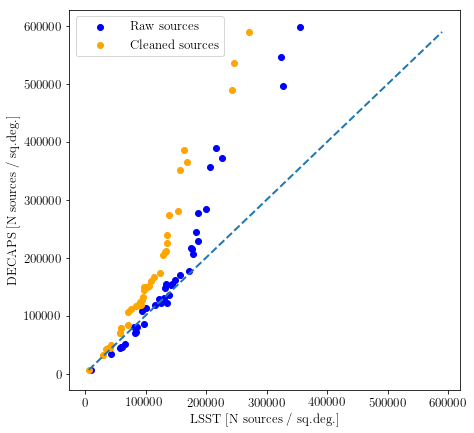

In [30]:
###2 
# Plot the number of raw,cleaned DECAPS vs LSST counts 
visit_tables = {}
for source in ['lsst','decaps']:
    visit_tables[source] = Table.read('visits_table_'+source+'_NEW1.txt', 
                                      format='ascii')
    
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(7,7))

for n,color,label in zip(['start','clean'],['blue', 'orange'],
                        ['Raw sources  ', 'Cleaned sources  ']):
    area_per_ccd = (2048 * 4096 * 0.27 * 0.27) / (3600 * 3600) # arcsec to degrees 
        
    area_per_visit = visit_tables['lsst']['Nccds'] * area_per_ccd
    lsst=  visit_tables['lsst']['N_'+n]  / area_per_visit

    area_per_visit = visit_tables['decaps']['Nccds'] * area_per_ccd
    decaps = visit_tables['decaps']['N_'+n]/ area_per_visit
    
    x = np.linspace(min(lsst),max(decaps),100)
    ax.scatter(lsst, decaps, c=color, label=label)
ax.plot(x,x, ls='--',lw=2)

ax.set_ylabel('DECAPS [N sources / sq.deg.]')
ax.set_xlabel('LSST [N sources / sq.deg.]')
#ax[1].set_xlabel('LSST N sources / sq.deg.')
ax.legend()
plt.savefig('decaps_lsst_source_count.png', bbox_inches='tight')



Change few column names ,and save in a $\LaTeX$ format that can be pasted directly to the report :

In [31]:
### 1
visit_tables = {}
for source in ['lsst','decaps']:
    visit_tables[source] = Table.read('visits_table_'+source+'_NEW1.txt', 
                                      format='ascii')
    
# Rename columns for the LaTeX  table
visit_tables_latex = visit_tables.copy()
    
old_cols = ['visit', 'N_start','N_removed_flags','N_removed_total',
           'N_clean', 'density','MAFnumber','N_per_sq_deg']
latex_cols = ['Visit','N raw','(N f)','-N r', 
            '=N c', 'N c/deg'+r'$^{2}$', 
              'N MAF/deg'+r'$^{2}$', r'$\rho_{MAF}$']

for source in visit_tables_latex.keys():
    for i in range(len(old_cols)):# in old_cols : 
        visit_tables_latex[source].rename_column(old_cols[i], latex_cols[i])

sel_cols = latex_cols

for source in visit_tables_latex.keys():
    save_fname = 'visits_table_'+source+'_NEW1_latex.txt'
    visit_tables_latex[source][sel_cols].write(save_fname, format='latex',
                       overwrite='True')
    print('Saved the LaTeX visit info summary for ',source,' in ',save_fname )



Saved the LaTeX visit info summary for  lsst  in  visits_table_lsst_NEW1_latex.txt
Saved the LaTeX visit info summary for  decaps  in  visits_table_decaps_NEW1_latex.txt



### Plot the clean counts only : LSST vs DECAPS, but with cuts at 20 and 19 .. .

In [7]:

# Plot the number of raw,cleaned DECAPS vs LSST counts 
visit_tables = {}
for source in ['lsst','decaps']:
    visit_tables[source] = Table.read('visits_table_'+source+'_NEW1.txt', 
                                      format='ascii')
    

In [13]:
for source in ['lsst','decaps']:
    for cut in [19,20]:
        visit_tables[source]['N_clean_lt_'+str(cut)] = 0
    for i,visit in enumerate(visit_tables[source]['visit']):
        print(i,visit)
        clean_catalog = Table.read(source+'_clean_'+str(visit)+'.txt', 
                                   format='ascii')
        mag = clean_catalog[source+'_mag']
        for cut in [19,20]:
            count = np.sum(mag < cut)
            visit_tables[source]['N_clean_lt_'+str(cut)][i] = count

0 568172
1 527319
2 530012
3 525846
4 525900
5 529989
6 529974
7 525814
8 527096
9 644125
10 611980
11 527247
12 567283
13 527246
14 640891
15 611970
16 645251
17 527296
18 611969
19 526413
20 525838
21 525837
22 611529
23 525920
24 527300
25 525904
26 527453
27 609754
28 530032
29 526152
30 567795
31 641497
32 527064
33 525879
34 644144
35 644082
36 526028
37 644074
38 641548
0 568172
1 527319
2 530012
3 525846
4 525900
5 529989
6 527096
7 525814
8 529974
9 644125
10 527247
11 527246
12 611980
13 527296
14 611970
15 645251
16 640891
17 525838
18 611969
19 527300
20 611529
21 525837
22 526413
23 525920
24 609754
25 525904
26 567283
27 526152
28 641497
29 530032
30 527453
31 525879
32 567795
33 644082
34 526028
35 527064
36 641548
37 644144
38 644074


In [16]:
#source='lsst'
#cut=20
#visit_tables[source]['N_clean_lt_'+str(cut)]

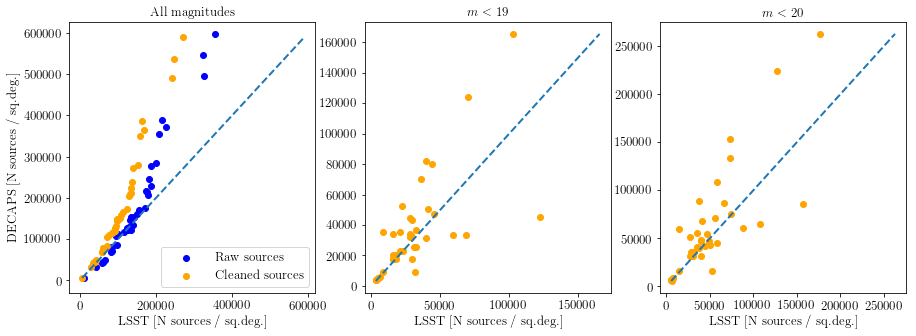

In [27]:
area_per_ccd = (2048 * 4096 * 0.27 * 0.27) / (3600 * 3600) # arcsec to degrees     


%matplotlib inline
fig,ax = plt.subplots(1,3,figsize=(15,5))

for n,color,label in zip(['start','clean'],['blue', 'orange'],
                        ['Raw sources  ', 'Cleaned sources  ']):
    
    area_per_visit = visit_tables['lsst']['Nccds'] * area_per_ccd
    lsst=  visit_tables['lsst']['N_'+n]  / area_per_visit

    area_per_visit = visit_tables['decaps']['Nccds'] * area_per_ccd
    decaps = visit_tables['decaps']['N_'+n]/ area_per_visit
    
    x = np.linspace(min(lsst),max(decaps),100)
    ax[0].scatter(lsst, decaps, c=color, label=label)
ax[0].plot(x,x, ls='--',lw=2)

for i in range(len(ax)):
    ax[i].set_xlabel('LSST [N sources / sq.deg.]')

ax[0].set_ylabel('DECAPS [N sources / sq.deg.]')
ax[0].legend()
ax[0].set_title('All magnitudes')

for i,cut in enumerate([19,20]) : 
    area_per_visit = visit_tables['lsst']['Nccds'] * area_per_ccd
    lsst=  visit_tables['lsst']['N_clean_lt_'+str(cut)]  / area_per_visit
    
    area_per_visit = visit_tables['decaps']['Nccds'] * area_per_ccd
    decaps=  visit_tables['decaps']['N_clean_lt_'+str(cut)]  / area_per_visit
    
    x = np.linspace(min(lsst),max(decaps),100)
    ax[i+1].scatter(lsst, decaps, c='orange')
    ax[i+1].plot(x,x, ls='--',lw=2)
    ax[i+1].set_title(r'$m< $'+' '+str(cut))
plt.savefig('decaps_lsst_source_count.png', bbox_inches='tight')




In [7]:
# NEW 
# 25% 525951, 525952
# 20% 525814, 525900 
# 15% 525837, 525838
# 10% 525846, 525879  
# 5%  525904, 525920

# OLD
# 25% 644125 , 568172
# 20% 611980 , 611529 , 609754
# 15% 611970 
# 10% 611969 
# 5% 527064 



## Read the decaps, lsst data  

Cross-match the DECAPS-LSST,  LSST-DECAPS catalogs. 

In [32]:
print('Using the DECAPS and LSST-cleaned catalogs')
i = 1
for visit in visits.astype(int):
    print('\nVisit ', i, ' of ', len(visits))
    decaps_lsst =  crossmatch_catalogs(sources=['decaps','lsst'],visits=[visit],
                        crossmatch_type = 'pipeline',
                       save_tables=True)
    
    lsst_decaps =  crossmatch_catalogs(sources=['lsst','decaps'],visits=[visit],
                        crossmatch_type = 'pipeline',
                       save_tables=True)
    i += 1 
print('Done crossmatching ') 

Using the DECAPS and LSST-cleaned catalogs

Visit  1  of  39
Cross-matching  decaps  to  lsst
There are  585141 decaps sources, 
   and  377506 lsst sources. 
 376097 cat1 srcs have a cat2 match within 0.5 arcsec
 391498 cat1 srcs have a  cat2 match within 0.5 mag
 372071 cat1 srcs have an cat2 match     fulfilling both criteria
Saving as  decaps-lsst-526152.txt
Cross-matching  lsst  to  decaps
There are  377506 lsst sources, 
   and  585141 decaps sources. 
 375558 cat1 srcs have a cat2 match within 0.5 arcsec
 373141 cat1 srcs have a  cat2 match within 0.5 mag
 371978 cat1 srcs have an cat2 match     fulfilling both criteria
Saving as  lsst-decaps-526152.txt

Visit  1  of  39
Cross-matching  decaps  to  lsst
There are  192547 decaps sources, 
   and  167570 lsst sources. 
 162467 cat1 srcs have a cat2 match within 0.5 arcsec
 168386 cat1 srcs have a  cat2 match within 0.5 mag
 162216 cat1 srcs have an cat2 match     fulfilling both criteria
Saving as  decaps-lsst-527096.txt
Cross-mat

There are  337105 decaps sources, 
   and  258364 lsst sources. 
 252746 cat1 srcs have a cat2 match within 0.5 arcsec
 263375 cat1 srcs have a  cat2 match within 0.5 mag
 251692 cat1 srcs have an cat2 match     fulfilling both criteria
Saving as  decaps-lsst-645251.txt
Cross-matching  lsst  to  decaps
There are  258364 lsst sources, 
   and  337105 decaps sources. 
 252592 cat1 srcs have a cat2 match within 0.5 arcsec
 254719 cat1 srcs have a  cat2 match within 0.5 mag
 251671 cat1 srcs have an cat2 match     fulfilling both criteria
Saving as  lsst-decaps-645251.txt

Visit  1  of  39
Cross-matching  decaps  to  lsst
There are  351448 decaps sources, 
   and  248399 lsst sources. 
 242498 cat1 srcs have a cat2 match within 0.5 arcsec
 254707 cat1 srcs have a  cat2 match within 0.5 mag
 240347 cat1 srcs have an cat2 match     fulfilling both criteria
Saving as  decaps-lsst-640891.txt
Cross-matching  lsst  to  decaps
There are  248399 lsst sources, 
   and  351448 decaps sources. 
 2422

Cross-matching  lsst  to  decaps
There are  268417 lsst sources, 
   and  365345 decaps sources. 
 250701 cat1 srcs have a cat2 match within 0.5 arcsec
 258684 cat1 srcs have a  cat2 match within 0.5 mag
 248912 cat1 srcs have an cat2 match     fulfilling both criteria
Saving as  lsst-decaps-611969.txt

Visit  1  of  39
Cross-matching  decaps  to  lsst
There are  1015036 decaps sources, 
   and  677231 lsst sources. 
 678217 cat1 srcs have a cat2 match within 0.5 arcsec
 698404 cat1 srcs have a  cat2 match within 0.5 mag
 666320 cat1 srcs have an cat2 match     fulfilling both criteria
Saving as  decaps-lsst-526028.txt
Cross-matching  lsst  to  decaps
There are  677231 lsst sources, 
   and  1015036 decaps sources. 
 675404 cat1 srcs have a cat2 match within 0.5 arcsec
 666678 cat1 srcs have a  cat2 match within 0.5 mag
 665639 cat1 srcs have an cat2 match     fulfilling both criteria
Saving as  lsst-decaps-526028.txt

Visit  1  of  39
Cross-matching  decaps  to  lsst
There are  138733

### Plotting counts and completeness : single panel per visit 

In [34]:
def plot_separation(decaps_lsst,color):
    x = decaps_lsst['d2darcsec']
    fig,ax = plt.subplots(1,1)
    ax.hist(x[x<0.3], bins=60, lw=2, ls='-', histtype='step')
    ax.set_xlabel('separation in arcsec')
    ax.set_ylabel('count')
    plt.savefig(str(visit)+'_separation.png', bbox_inches='tight')
    plt.show()
    
## Plot the count of objects before cross-matching :
def plot_counts(decaps,lsst,visit,ax,bins):
    ax.hist(decaps['decaps_mag'], lw=2, histtype='step', bins=bins,
           label='raw DECAPS ')
    ax.hist(lsst['lsst_mag'], lw=2, histtype='step', bins=bins,
           label='raw LSST ')
    ax.legend(loc='upper left')
    ax.set_xlabel('mag')
    ax.set_ylabel('count')
    ax.set_title(str(visit))
    ax.grid()
    
def plot_count_after(decaps_lsst,visit,ax,bins):
    # Plot the count of objects as a function of magnitude ...
    m = decaps_lsst['lsst_match'] == 1 
    ax.hist(decaps_lsst['decaps_mag'][m], lw=2, histtype='step', bins=bins,
            label='matched DECAPS ')
    ax.hist(decaps_lsst['lsst_mag'][m], lw=2, histtype='step', bins=bins,
           label='matched LSST ')
    ax.legend(loc='upper left')
    ax.set_xlabel('mag')
    ax.set_ylabel('count')
    ax.grid()
    
def plot_completeness(decaps_lsst, visit,ax,bins):
    # Plot completeness for this single visit ...    
    stat_decaps = bs(decaps_lsst['decaps_mag'], decaps_lsst['decaps_mag'] , 
                  bins = bins , statistic='count')
    decaps_count = stat_decaps.statistic

    stat_matched = bs(decaps_lsst['decaps_mag'], decaps_lsst['lsst_match'] , 
                        bins =bins , statistic=np.sum)
    lsst_matched_count = stat_matched.statistic
    completeness = 100 * (lsst_matched_count / decaps_count)

    # plot 
    # from bin edges to bin_centers.... 
    bin_centers = (bins[:-1] + bins[1:])/2
    
    ax.plot(bin_centers, completeness)
    ax.scatter(bin_centers, completeness)
    ax.set_xlabel('DECAPS mag ')
    ax.set_ylabel('completeness LSST to DECAPS %')
    ax.grid()

def plot_dmag(decaps_lsst,visit,ax,bins):
    mask_distance = decaps_lsst['d2darcsec'].data < 0.5
    x = decaps_lsst[mask_distance]['decaps_mag']
    y = decaps_lsst[mask_distance]['lsst_mag']
    dm = y-x 
    
    # calculate the spread : sigmaG 
    spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
    sig = spread_sig.statistic

    # calculate the median per bin 
    median = bs(x,dm, bins=bins,statistic='median')
    med = median.statistic
    
    # from bin edges to bin_centers.... 
    bin_centers = (bins[:-1] + bins[1:])/2
    
    # plotting
    ax.scatter(x,y-x,s=0.001)
    ax.set_ylim(-0.3, 0.3)
    ax.scatter(bin_centers , med ,s=30,c='yellow', edgecolors='k',
              label='median')
    ax.plot(bin_centers, med+sig, ls='--', lw=2, c='magenta', label=r'$\pm \sigma_{G}$')
    ax.plot(bin_centers, med-sig, ls='--', lw=2, c='magenta')
    ax.legend(loc='upper left')
    ax.set_xlabel('DECAPS mag')
    ax.set_ylabel('LSST-DECAPS mag')
    ax.grid()

NameError: name 'decaps_clean' is not defined

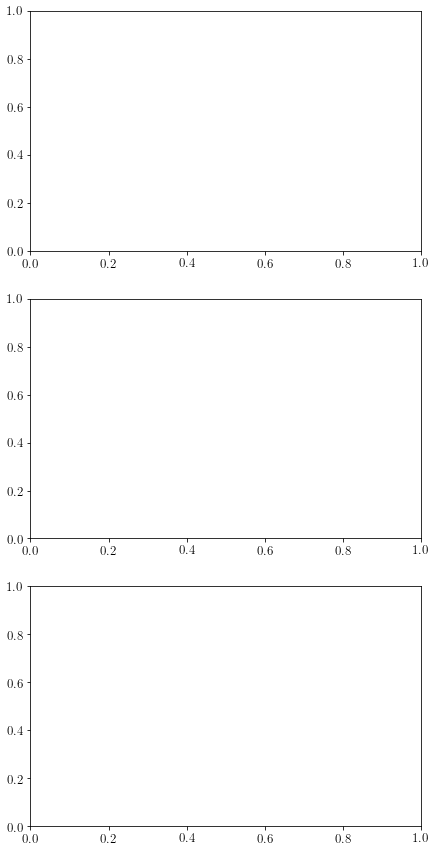

In [35]:
# plotting ....
for visit in visits[:2] :  
    
    # initialize the plottig space 
    fig,ax = plt.subplots(3,1,figsize=(7,15))
    bins = np.arange(14,24,0.25)
    
    # read in the clean DECAPS-LSST data 
    decaps_lsst = Table.read('decaps-lsst-'+str(visit)+'.txt', format='ascii')
    
    # read in the clean LSST data
    lsst_clean = Table.read('lsst_clean_'+str(visit)+'.txt', format='ascii')
    
    # plot raw counts for clean catalogs 
    plot_counts(decaps_clean,lsst_clean,visit, ax[0],bins)
    
    # plot completeness 
    plot_completeness(decaps_lsst, visit,ax[1],bins)
    
    # plot magnitude scatter
    plot_dmag(decaps_lsst,visit,ax[2],bins)
    for i in range(len(ax)):
        ax[i].set_xlim(13.5,23.5)
    plt.savefig('panels_'+str(visit)+'.png', bbox_inches='tight')

** One panel completeness, color by actual source densities **

In [36]:
def multiplot_count(x,ax,bins,density,color='k',marker='*', step=False, normed=True):
    ''' Compute the count per bin using scipy
    binned statistic. More versatile than histogram. 
    
    Parameters :
    ----------------
    normed : if True,  then normalizing by the total
        number of counts within the histogram bounds 
        ( not including anything beyond the scale of 
        the plot)
    '''
    stat_count = bs(x,x,bins=bins, statistic='count')
    bin_centers = (bins[:-1] + bins[1:])/2
    count = stat_count.statistic 
    if normed : 
        count /= np.sum(count)
    if step : 
        ax.step(bin_centers, count, c=color, label=str(density))
    else : 
        ax.plot(bin_centers, count, c=color, marker=marker)
        #ax.scatter(bin_centers,count,c=color)


def multiplot_completeness(table, visit,ax,bins,density,color,marker,
                           source1='decaps',
                           source2='lsst',
                          sep=0.5, dmag=0.5, ):
    '''
    We assume that source1 is matched to source2: 
    we ask how many objects from source1  have a match in source2. 
    This is expressed in terms of completeness. Source1 is 
    thus considered the 'truth'. The completeness is plotted 
    as a function of magnitude of source1. In the middle and 
    bottom panel we see counts as a function of magnitude for 
    source1 and source2. 
    '''
    # Plot completeness for this single visit ...    
    #bins = np.arange(14,24,0.5)
    
    # calculate the 'match' 
    table['match'] = 0
    mask_separation = table['d2darcsec'] < sep
    mask_dmag = np.abs(table['decaps_mag']-table['lsst_mag'])< dmag
    mask = mask_separation * mask_dmag
    print(np.sum(mask_separation))
    print(np.sum(mask_dmag))
    print(np.sum(mask))
    
    table['match'][mask] = 1 
    
    # calculate the plotted stats
    stat_decaps = bs(table[source1+'_mag'], table[source1+'_mag'] , 
                  bins = bins , statistic='count')
    cat1_count = stat_decaps.statistic

    stat_matched = bs(table[source1+'_mag'],table['match'] , 
                        bins =bins , statistic=np.sum)
    cat2_matched_count = stat_matched.statistic
    completeness = 100 * (cat2_matched_count / cat1_count)
    # from bin edges to bin_centers.... 
    bin_centers = (bins[:-1] + bins[1:])/2
    
    # the mean completeness 18-20 mag 
    m = (18 <= bin_centers) * (bin_centers <= 20)
    c1820 = np.mean(completeness[m])
    print('C 18-20 = ',c1820)
    
    # the magnitude of 50% completeness
    # interpolate sorted y values :
    # find x at which y = 50 % 
    
    y = completeness[18<bin_centers]
    x = bin_centers[18<bin_centers]
    indices = np.argsort(y)
    xp = np.interp(50, y[indices],x[indices])
    m50 = xp
    print('The m50 =', m50)
    ax.plot(bin_centers, completeness,c=color, marker=marker)
    return m50,  c1820
    #ax.scatter(bin_centers, completeness,c=color)



In [120]:
decaps_lsst = Table.read('decaps-lsst-'+str(visit)+'.txt', format='ascii')

In [124]:
#decaps_lsst

### DECAPS to LSST 

In [39]:
from astropy.table import join
# Read the stats tables ...
visit_tables = {}
for source in ['lsst','decaps']:
    visit_tables[source] = Table.read('visits_table_'+source+'_NEW1.txt', 
                                      format='ascii')
    
# Make a cross-matched table 

visit_table = join(left=visit_tables['lsst'], right=visit_tables['decaps'],
                   keys='visit', join_type='inner', table_names=['lsst','decaps'])

# need to use the mean DECAPS-LSST counts to 
# express the mean number of counts per square degree 
visit_table['mean_N_per_sq_deg'] = (visit_table['N_per_sq_deg_lsst'] +\
    visit_table['N_per_sq_deg_decaps'])/2.0

visit_table.write('decaps_lsst_visit_info.txt', format='ascii',
                 overwrite='True')



In [104]:
# some other plotting ;///
plt.scatter(visit_table['N_per_sq_deg_lsst'],visit_table['N_per_sq_deg_lsst'],
           c='green')
plt.scatter(visit_table['N_per_sq_deg_lsst'],visit_table['mean_N_per_sq_deg'],
           c='blue')
plt.scatter(visit_table['N_per_sq_deg_lsst'], visit_table['N_per_sq_deg_decaps'],
           c='orange')

In [160]:
# Testing the legend positiopn ... 
ax_handles = []
for i in range(15):
    line = mlines.Line2D([], [], color=color, marker=marker,
                             label=visit)
    ax_handles.append(line)
    
fig,ax = plt.subplots(3,1,figsize=(8,12))
cax,kw = matplotlib.colorbar.make_axes([ax for ax in ax.flat],
                                          aspect=50)
plt.colorbar(sm, cax=cax,
                 label='N sources per sq.degree') 

plt.legend(bbox_to_anchor=(7.6,1),handles = ax_handles)

source1, source2: decaps lsst
i= 0 / 37   530012
92550
96779
92098
C 18-20 =  88.4009108014
The m50 = 23.02206983886283


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 1 / 37   525846
96550
101256
96070
C 18-20 =  88.958875197
The m50 = 23.123698965882298


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 2 / 37   525900
106548
110337
106286
C 18-20 =  89.5808989288
The m50 = 23.584494604247933


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 3 / 37   529989
112542
118441
112235
C 18-20 =  88.0255935812
The m50 = 23.625


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 4 / 37   525814
154372
162053
153561
C 18-20 =  89.8724610232
The m50 = 22.60904299024549


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 5 / 37   527096
162467
168386
162216
C 18-20 =  86.9178947695
The m50 = 20.378184290831896


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 6 / 37   529974
154254
162982
152820
C 18-20 =  90.0212982197
The m50 = 22.577886589001054


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 7 / 37   644125
163395
171788
162348
C 18-20 =  78.5386042514
The m50 = 21.078585849474514


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 8 / 37   527247
194955
202137
194665
C 18-20 =  90.4909560205
The m50 = 21.7566892160166


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 9 / 37   611980
185667
202973
184535
C 18-20 =  80.6206858315
The m50 = 21.935252350470005


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 10 / 37   527246
229347
239990
228584
C 18-20 =  88.8480983413
The m50 = 22.875


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 11 / 37   527296
256410
268452
255609
C 18-20 =  88.9029816474
The m50 = 22.178061994521347


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 12 / 37   645251
252746
263375
251692
C 18-20 =  83.2006615326
The m50 = 21.202034908971278


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 13 / 37   611970
239595
260264
237967
C 18-20 =  82.5105445715
The m50 = 22.506507551544825


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 14 / 37   640891
242498
254707
240347
C 18-20 =  86.1171561057
The m50 = 22.640976994911554


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 15 / 37   525838
266402
278654
265228
C 18-20 =  

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


88.4926694917
The m50 = 22.55231700449969
i= 16 / 37   611969
250944
269226
248936
C 18-20 =  81.0967079251
The m50 = 22.327504594982308


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 17 / 37   526413
266634
279944
264737
C 18-20 =  86.8649722386
The m50 = 22.18231190408117


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 18 / 37   525837
284008
296192
282064
C 18-20 =  88.9318886632
The m50 = 22.810051842301394


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 19 / 37   611529
276720
299879
274426
C 18-20 =  83.1720669082
The m50 = 22.580307902224256


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 20 / 37   527300
312345
326081
310930
C 18-20 =  89.2857004731
The m50 = 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


22.472119450472228
i= 21 / 37   525920
297764
313918
295766
C 18-20 =  87.5334178825
The m50 = 22.604411552898366
i= 22 / 37   567283
203221
226511
201582
C 18-20 =  78.8190155884
The m50 = 20.443684050912942


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 23 / 37   525904
337833
353156
335254
C 18-20 =  88.2369506143
The m50 = 22.756839828102336


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 24 / 37   609754
348014
373984
345570
C 18-20 =  86.0887769291
The m50 = 22.45570219833987


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 25 / 37   526152
376097
391498
372071
C 18-20 =  87.3304584988
The m50 = 23.201863184711275


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 26 / 37   641497
390368
404185
386694
C 18-20 =  86.953604508
The m50 = 22.228310711486174


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 27 / 37   530032
367490
386204
365059
C 18-20 =  83.6919815401
The m50 = 21.430842650433195


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 28 / 37   527453
354265
373711
348620
C 18-20 =  80.0833404736
The m50 =

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


 20.652060302232293
i= 29 / 37   567795
375330
403356
370683
C 18-20 =  83.6673347536
The m50 = 21.505321003848575


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 30 / 37   525879
434066
451676
429440


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


C 18-20 =  85.2087145288
The m50 = 21.962222928240845
i= 31 / 37   644082
460037
487165
452340


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


C 18-20 =  78.8906157555
The m50 = 20.51562684328567
i= 32 / 37   527064
413410
456760
408178


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


C 18-20 =  84.9845340624
The m50 = 21.528381273578074
i= 33 / 37   526028
678217
698404
666320


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


C 18-20 =  87.603359723
The m50 = 22.981007142837036
i= 34 / 37   644144
433817
473857
422875


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


C 18-20 =  47.4959066292
The m50 = 18.8887604027245
i= 35 / 37   641548
765439
798620
749220


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


C 18-20 =  84.6951007968
The m50 = 21.582137135855774
i= 36 / 37   644074
696727
730270
674718


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


C 18-20 =  78.4696495051
The m50 = 20.530649163074123


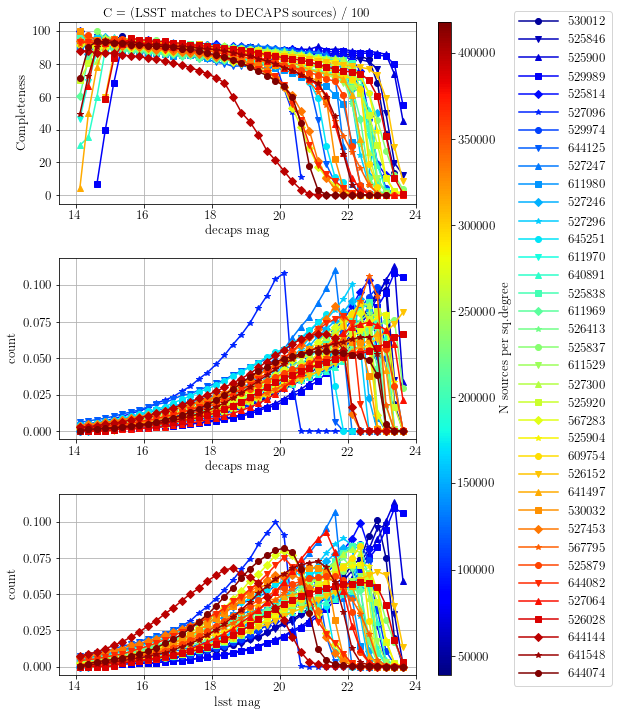

source1, source2: lsst decaps
i= 0 / 37   530012
92514
94370
92093
C 18-20 =  99.5781009453
The m50 = 23.2150263758868


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 1 / 37   525846
96525
98806
96064
C 18-20 =  99.2565803315
The m50 = 23.241984030308338


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 2 / 37   525900
106519
108491
106283
C 18-20 =  99.5422126789
The m50 = 23.60922724306831


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 3 / 37   529989
112505
115926
112229
C 18-20 =  98.3372191419
The m50 = 23.625


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 4 / 37   525814
154326
157562
153558
C 18-20 =  99.1134500311
The m50 = 22.834386717503182


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 5 / 37   527096
162435
164137
162211
C 18-20 =  98.8274208813
The m50 = 20.452580472004552


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 6 / 37   529974
154230
155900
152816
C 18-20 =  99.4265359519
The m50 = 22.97899571430404


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 7 / 37   644125
163349
165781
162345
C 18-20 =  97.7931260082
The m50 = 21.395762881178328


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 8 / 37   527247
194890
195761
194657
C 18-20 =  99.6720221235
The m50 = 21.998056882676465


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 9 / 37   611980
185655
194011
184530
C 18-20 =  94.4087895453
The m50 = 22.533335153737053


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 10 / 37   527246
229273
230894
228569
C 18-20 =  98.8043760214
The m50 = 22.69709573847052


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 11 / 37   527296
256125
257931
255562
C 18-20 =  99.1135068127
The m50 = 22.513934410036942


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 12 / 37   645251
252592
254719
251671
C 18-20 =  98.7781143909
The m50 = 21.59796241763423


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 13 / 37   611970
239278
251048
237942
C 18-20 =  93.7613195752
The m50 = 22.870687731477112


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 14 / 37   640891
242296
244342
240330
C 18-20 =  98.1169484834
The m50 = 23.071180306162784


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 15 / 37   525838
266255
267503
265206
C 18-20 =  99.2083684222
The m50 = 22.934310255306215


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 16 / 37   611969
250701
258684
248912
C 18-20 =  93.6321520854
The m50 = 22.877072628902813


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 17 / 37   526413
266477
266398
264717
C 18-20 =  99.3367516889
The m50 = 22.819327250421715


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 18 / 37   525837
283843
283496
282040
C 18-20 =  99.4541856934
The m50 = 23.602448512353995


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 19 / 37   611529
276463
286957
274401
C 18-20 =  94.5918508856
The m50 = 23.040539632856213


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 20 / 37   527300
311854
313348
310836
C 18-20 =  99.207604647
The m50 = 22.813268258148163


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 21 / 37   525920
297569
299285
295729
C 18-20 =  

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


98.4692893706
The m50 = 23.277621404264377
i= 22 / 37   567283
203210
208783
201577
C 18-20 =  95.5110116412
The m50 = 22.25223926380368


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 23 / 37   525904
337328
338003
335165
C 18-20 =  98.4132879752
The m50 = 23.2923907085611


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 24 / 37   609754
346909
360723
345365
C 18-20 =  95.0071027795
The m50 = 22.750699144895083


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 25 / 37   526152
375558
373141
371978
C 18-20 =  99.5917465902
The m50 = 23.625


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 26 / 37   641497
389884
388484
386634
C 18-20 =  99.3122818875
The m50 = 22.928266202036326


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 27 / 37   530032
367393
368194
365038
C 18-20 =  98.7471290489
The m50 = 22.2924316698307


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 28 / 37   527453
353405
350332
348436
C 18-20 =  98.565750355
The m50 = 21.882960413080895


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 29 / 37   567795
375044
373728
370599
C 18-20 =  98.8095977321
The m50 = 22.993460470056373


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 30 / 37   525879
433676
432119
429382
C 18-20 =  99.0357985466
The m50 = 22.765130292908925


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 31 / 37   644082
458668
454473
452095
C 18-20 =  98.5721968356
The m50 = 22.19440273857426


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 32 / 37   527064
413094
417695
408095
C 18-20 =  97.4198307621
The m50 = 22.741323096339926


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 33 / 37   526028
675404
666678
665639


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


C 18-20 =  99.4985908179
The m50 = 23.625
i= 34 / 37   644144
432554
431905
422615


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


C 18-20 =  93.6418454137
The m50 = 21.337805496735488
i= 35 / 37   641548
761285
752798
748409
C 18-20 =  98.9195148206
The m50 = 22.459314762065254


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


i= 36 / 37   644074
692019
678398
673782
C 18-20 =  98.3063718383
The m50 = 21.29768730139559


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


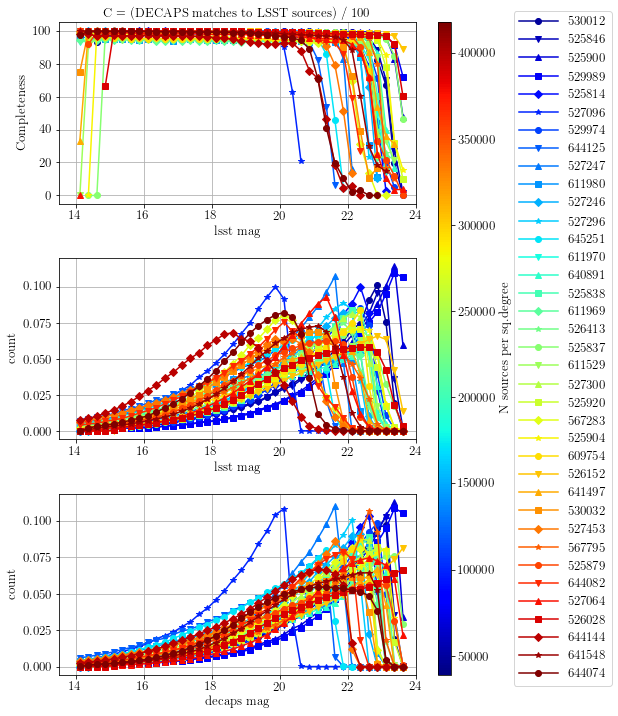

In [46]:
%matplotlib inline 

import matplotlib
import matplotlib.lines as mlines
cmap = matplotlib.cm.get_cmap('jet')

# Plot all visits on one panel... 
source = 'lsst'
visits_table_lsst = visit_table
visits_table_lsst.sort('mean_N_per_sq_deg') # sort by source count  

ls = ['--', '']
#N= 4
visits  = visits_table_lsst['visit'][2:]
densities = visits_table_lsst['mean_N_per_sq_deg'][2:]
N = len(densities)

markers = ['o','v', '^','s','D','*']

# 'the regular:  how many decaps sources have and 
# lsst equivalent ...   decaps, lsst 

sources_dics = {}
for source1,source2 in [['decaps','lsst'],['lsst','decaps']]:
    print('source1, source2:', source1, source2)
    fig,ax = plt.subplots(3,1,figsize=(8,12))
    bins = np.arange(14,24,0.25)
    ax_legend_handles = []
    compl_stats = {'m50':np.zeros_like(visits, dtype=float),
                  'c1820':np.zeros_like(visits, dtype=float),
                  'visit':np.zeros_like(visits),
                  'density':np.zeros_like(visits, dtype=float)}
    i = 0 
    for visit in visits.astype(int) : 
        density = int(densities[i])
        print('i=',i,'/',N,' ', visit)

        color = cmap((i+1)/N)
        marker = markers[i%len(markers)]  # go in the loop over markers

        line = mlines.Line2D([], [], color=color, marker=marker,
                             label=visit)
        ax_legend_handles.append(line)
        
        # reading the cross-matched  lsst-decaps data
        cat = Table.read(source1+'-'+source2+'-'+str(visit)+'.txt', format='ascii')
        m50,  c1820= multiplot_completeness(cat, visit,ax[0],bins,density, color,marker,
                               source1=source1,
                               source2=source2)
        compl_stats['visit'][i] = visit
        compl_stats['density'][i] = density
        compl_stats['m50'][i] = m50
        compl_stats['c1820'][i] = c1820
        
        # plot count of input clean DECAPS
        multiplot_count(cat[source1+'_mag'],ax[1],bins,density,color,marker)

        # plot count of input clean LSST
        cat2 = Table.read(source2+'_clean_'+str(visit)+'.txt', format='ascii')
        multiplot_count(cat2[source2+'_mag'],ax[2],bins,density,color,marker)
        i += 1 
        
    sources_dics[source1] = compl_stats
    
    ax[0].set_xlabel(source1+' mag ')
    ax[0].set_ylabel('Completeness')
    if source1 is 'decaps':
        ax[0].set_title('C = (LSST matches to DECAPS sources) / 100 ')
    if source1 is 'lsst':
        ax[0].set_title('C = (DECAPS matches to LSST sources) / 100 ')
        
    ax[1].set_xlabel(source1+' mag')
    ax[1].set_ylabel(' count')
    fig.subplots_adjust(hspace=0.3)
    # Make a quick mappable to get a nice colorbar ... 
    # https://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(densities), 
                                                          vmax=max(densities)))
    sm._A = []
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in ax.flat],
                                          aspect=50)
    plt.colorbar(sm, cax=cax,
                 label='N sources per sq.degree') 
    
    plt.legend(bbox_to_anchor=(5.3,0.5),
             fancybox=True, loc="center left",
             handles = ax_legend_handles)
    
    ax[2].set_xlabel(source2+' mag')
    ax[2].set_ylabel(' count')

    #plot_dmag(decaps_lsst,visit,ax[3],bins)
    for i in range(len(ax)):
        ax[i].set_xlim(13.5,24)
        ax[i].grid()

    plt.savefig('completeness_count_'+source2+'_'+source1+'_N.png', 
                bbox_inches='tight')
    plt.show()

In [44]:
sources_dics['decaps']

{'c1820': <Column name='visit' dtype='float64' length=2>
 88.4009108014
  88.958875197, 'density': <Column name='visit' dtype='float64' length=2>
 38865.0
 40602.0, 'm50': <Column name='visit' dtype='float64' length=2>
 23.0220698389
 23.1236989659, 'visit': <Column name='visit' dtype='int64' length=2>
 530012
 525846}

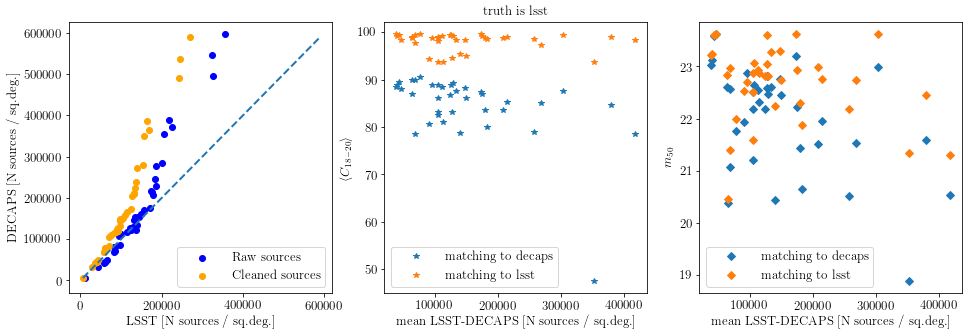

In [51]:
###2 
# Plot the number of raw,cleaned DECAPS vs LSST counts 
visit_tables = {}
for source in ['lsst','decaps']:
    visit_tables[source] = Table.read('visits_table_'+source+'_NEW1.txt', 
                                      format='ascii')
    
%matplotlib inline

fig,ax = plt.subplots(1,3,figsize=(16,5))

for n,color,label in zip(['start','clean'],['blue', 'orange'],
                        ['Raw sources  ', 'Cleaned sources  ']):
    area_per_ccd = (2048 * 4096 * 0.27 * 0.27) / (3600 * 3600) # arcsec to degrees 
        
    area_per_visit = visit_tables['lsst']['Nccds'] * area_per_ccd
    lsst=  visit_tables['lsst']['N_'+n]  / area_per_visit

    area_per_visit = visit_tables['decaps']['Nccds'] * area_per_ccd
    decaps = visit_tables['decaps']['N_'+n]/ area_per_visit
    
    x = np.linspace(min(lsst),max(decaps),100)
    ax[0].scatter(lsst, decaps, c=color, label=label)
    
ax[0].plot(x,x, ls='--',lw=2)

ax[0].set_ylabel('DECAPS [N sources / sq.deg.]')
ax[0].set_xlabel('LSST [N sources / sq.deg.]')
#ax[1].set_xlabel('LSST N sources / sq.deg.')
ax[0].legend()

for truth in ['decaps', 'lsst']:
    ax[1].plot(sources_dics[truth]['density'],sources_dics[truth]['c1820'],
              marker = '*', label='matching to '+truth, ls=' ')
    ax[1].set_ylabel(r'$\langle C_{18-20} \rangle$')
    ax[1].set_title('truth is '+ truth)
    ax[1].legend()
    ax[2].plot(sources_dics[truth]['density'], sources_dics[truth]['m50'],
              marker='D', ls=' ',label='matching to '+truth)
    ax[2].set_ylabel(r'$m_{50}$')
    ax[2].legend()
    ax[1].set_xlabel('mean LSST-DECAPS [N sources / sq.deg.]')
    ax[2].set_xlabel('mean LSST-DECAPS [N sources / sq.deg.]')

plt.savefig('decaps_lsst_source_count_multiplot_'+truth+'.png', bbox_inches='tight')




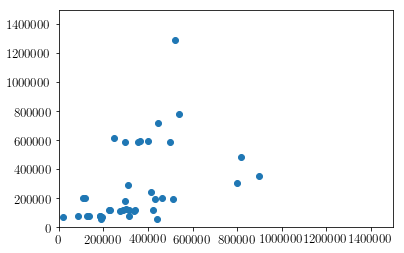

In [209]:
plt.xlim(0,1500000)
plt.ylim(0,1500000)
plt.scatter(visit_table['N_clean_lsst'],visit_table['MAFnumber_lsst'])

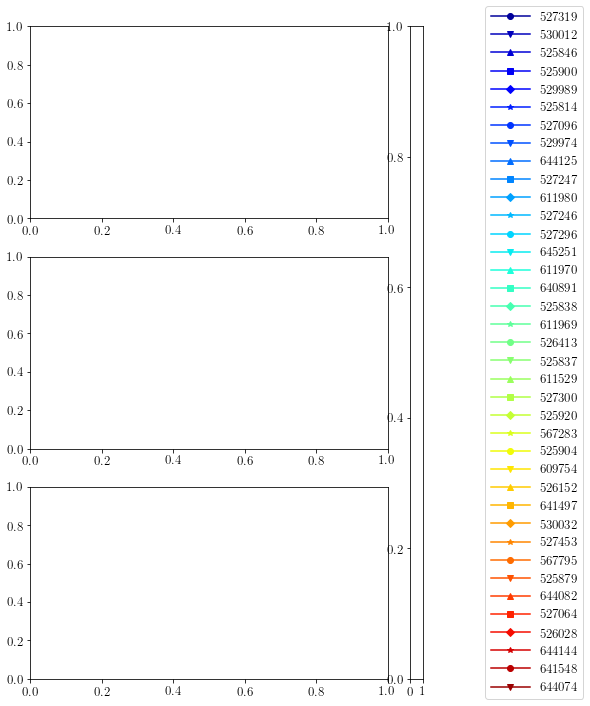

In [199]:
# Testing the legend ....
fig,ax = plt.subplots(3,1,figsize=(8,12))
cax,kw = matplotlib.colorbar.make_axes([ax for ax in ax.flat],
                                          aspect=50)
plt.legend(bbox_to_anchor=(5.3,0.5),
             fancybox=True, loc="center left",
             handles = ax_legend_handles)

**OLD :  One panel completeness - color by MAF **

In [273]:
densities = list(visit_density_dic.keys())
densities

['20', '15', '10', '5']

20
    611529


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


    609754


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


    525814


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


    525900


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


15
    611970


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


    525837


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


    525838


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


10
    611969


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


    525846


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


    525879


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


5
    525904


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


    525920


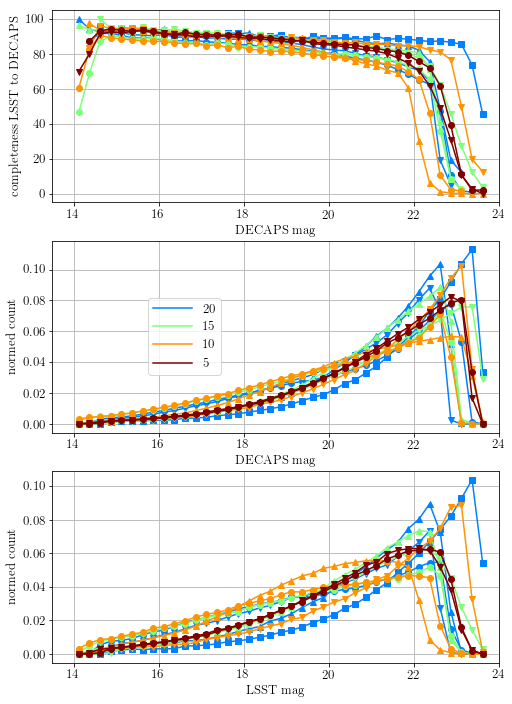

In [305]:
%matplotlib inline 
# Plot all visits on one panel... 

use_old = True 
if use_old :
    visit_density_dic = {'25g,t1' : 644125, '25g,t2':568172, '20g':611980,
                         '20r': 611529, '20i': 609754, '15':611970, 
                         '10':611969, '5':527064}
else : 
    visit_density_dic = {'25g1': 525951, '25g2': 525952, '20g1':525814,
                    '20g2':525900, '15g1':525837, '15g2':525838,
                    '10g1':525846, '10g2':525879, '5g1':525904,
                    '5g2':525920}

visit_density_dic = {'20':[611529,609754,525814,525900],
                     '15':[611970,525837,525838],
                     '10':[611969,525846,525879],
                     '5':[525904,525920]}    
    
ls = ['--', '']
# NEW : 
# 25% 525951, 525952
# 20% 525814, 525900 
# 15% 525837, 525838
# 10% 525846, 525879  
# 5%  525904, 525920

# OLD : all downloaded 
# 25% 644125 , 568172
# 20% 611980 , 611529 , 609754
# 15% 611970 
# 10% 611969 
# 5% 527064 


# Check if all files are present 
#visits = list(np.ravel(visit_density_dic.values()))
#decaps_lsst_files = [x for x in os.listdir() if x.startswith('decaps-lsst-')]
#decaps_sought = ['decaps-lsst-'+str(visit)+'.txt' for visit in visits]
#mask_needed = np.bitwise_not(np.in1d(decaps_sought, decaps_lsst_files))
#if np.sum(mask_needed) > 0 : 
#    print('Need to cross-match',np.array(decaps_sought)[mask_needed])

#else : # go ahead and plot only if files present 
fig,ax = plt.subplots(3,1,figsize=(8,12))
bins = np.arange(14,24,0.25)
import matplotlib
import matplotlib.lines as mlines
cmap = matplotlib.cm.get_cmap('jet')
densities = list(visit_density_dic.keys())
N = len(densities)
i = 0 
ax_legend_handles = []
markers = ['o','v', '^','s','D','*']
for density in densities : 
    print(density)
    visits = visit_density_dic[density]
    color = cmap((i+1)/N)
    
    # add a line to the density legend... 
    line = mlines.Line2D([], [], color=color, label=density+'%')
    ax_legend_handles.append(line)
    j = 0
    for visit in visits: 
        marker = markers[j]
        print('   ', visit)
        # reading the cross-matched  lsst-decaps data
        decaps_lsst = Table.read('decaps-lsst-'+str(visit)+'.txt', format='ascii')
        multiplot_completeness(decaps_lsst, visit,ax[0],bins,density, color,marker)

        # plot count of inout clean DECAPS
        multiplot_count(decaps_lsst['decaps_mag'],ax[1],bins,density,color,marker)

        # plot count of input clean LSST
        lsst_clean = Table.read('lsst_clean_'+str(visit)+'.txt', format='ascii')
        multiplot_count(lsst_clean['lsst_mag'],ax[2],bins,density,color,marker)
        j += 1 
    i += 1 

ax[0].set_xlabel('DECAPS mag ')
ax[0].set_ylabel('completeness LSST to DECAPS %')

ax[1].set_xlabel('DECAPS mag')
ax[1].set_ylabel('normed count')

ax[1].legend(bbox_to_anchor=(0.2,0.5),
             fancybox=True, loc="center left",
             handles = ax_legend_handles)

ax[2].set_xlabel('LSST mag')
ax[2].set_ylabel('normed count')

#plot_dmag(decaps_lsst,visit,ax[3],bins)
for i in range(len(ax)):
    ax[i].set_xlim(13.5,24)
    ax[i].grid()
plt.savefig('completeness_count_lsst_decaps.png', bbox_inches='tight')
plt.show()

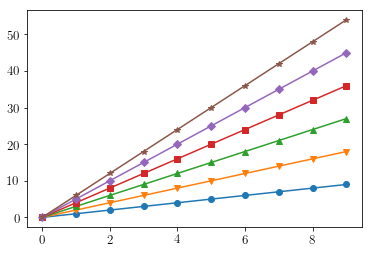

In [302]:
x = np.arange(10)
marker = ['o','v', '^','s','D','*']
for i in range(len(marker)):
    m  = marker[i]
    plt.plot(x,(i+1)*x,marker=m, label=m)
#plt.legend()

In [169]:
#decaps_sought

In [168]:
#decaps_lsst_files

# RMS : LSST_DECAPS comparison of the photometric scatter 

15 611970


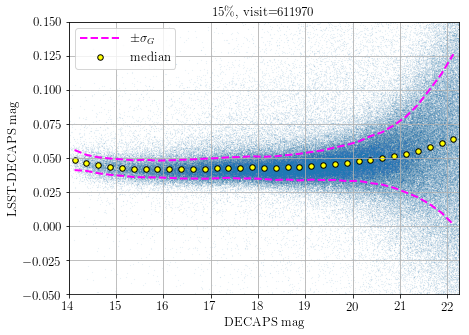

In [313]:


def plot_dmag(decaps_lsst,visit,ax,bins):
    #bins = np.arange(14,23,0.5)
    mask_distance = decaps_lsst['d2darcsec'].data < 0.5
    x = decaps_lsst[mask_distance]['decaps_mag']
    y = decaps_lsst[mask_distance]['lsst_mag']
    dm = y-x 
    
    # calculate the spread : sigmaG 
    spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
    sig = spread_sig.statistic

    # calculate the median per bin 
    median = bs(x,dm, bins=bins,statistic='median')
    med = median.statistic
    
    # from bin edges to bin_centers.... 
    bin_centers = (bins[:-1] + bins[1:])/2
    
    # plotting
    #fig,ax = plt.subplots(1,1)
    ax.scatter(x,y-x,s=0.001, label='')
    ax.set_xlim(bins[0], bins[-1])
    ax.set_ylim(-0.05, 0.15)
    ax.scatter(bin_centers , med ,s=30,c='yellow', edgecolors='k',
              label='median')
    ax.plot(bin_centers, med+sig, ls='--', lw=2, c='magenta', label=r'$\pm \sigma_{G}$')
    ax.plot(bin_centers, med-sig, ls='--', lw=2, c='magenta')
    ax.legend(loc='upper left')
    ax.set_xlabel('DECAPS mag')
    ax.set_ylabel('LSST-DECAPS mag')
    ax.grid()
    #ax.set_title(str(visit))
    #plt.savefig(str(visit)+'_half_arcsec_matches1.png', bbox_inches='tight')
    #plt.show()
bins = np.arange(14,22.5,0.25)
for density in ['15'] : # ['25'] : # : # ['25']:# densities : 
     #  ['25']:# in visits :# [611980] : #visits: 
    fig,ax= plt.subplots(1,1,figsize=(7,5))
    visit = visit_density_dic[density][0]
    print(density, visit) 
    decaps_lsst = Table.read('decaps-lsst-'+str(visit)+'.txt', format='ascii')
    plot_dmag(decaps_lsst,visit,ax,bins) 
    ax.set_title(density+'\%'+', visit='+str(visit))
    plt.savefig('decaps_lsst_dmag_density_'+density+'.png', bbox_inches='tight')
# We positionally cross match DECAPS and LSST catalogs, and plot the 
# magnitude difference for objects within 0.5 arcsec from each other. 
# The median and sigmaG are calculated on full sample, i.e. 
# no clip on magnitude difference. 

# For completeness we also assumed that a match has to be within 
# 0.5 magnitude , but this does not affect median and sigmaG 
# which are not sensitive to rare outliers (objects 
# that are spatially close, but have a magnitude difference larger 
# than 0.5 magnitudes  )

In [309]:
a = density+'%'+'visit='+str(visit)
print(a)

15%visit=611970


visit,N_start_lsst,N_removed_flags_lsst,N_removed_negFlux_lsst,N_removed_lowSN_lsst,N_removed_total_lsst,N_clean_lsst,density_lsst,MAFnumber_lsst,Nccds_lsst,N_per_sq_deg_lsst,N_dimless_lsst,N_low_SN_lsst,N_start_decaps,N_removed_flags_decaps,N_removed_negFlux_decaps,N_removed_lowSN_decaps,N_removed_total_decaps,N_clean_decaps,density_decaps,MAFnumber_decaps,Nccds_decaps,N_per_sq_deg_decaps,N_dimless_decaps,N_low_SN_decaps,mean_N_per_sq_deg
int64,int64,int64,int64,int64,int64,int64,float64,int64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,float64,int64,int64,int64,float64,int64,float64
568172,29809,9148,1112,11874,11877,17932,0.213,72072,59,6441,0.000249814793602,12986,16824,138,0,18,150,16674,0.213,72072,59,5989,0.000232283930893,18,6215.0
527319,120862,13744,1249,33033,33204,87658,0.199,79632,59,31486,0.00122118748507,34282,92326,2819,60,396,3039,89287,0.199,79632,59,32071,0.00124387676535,456,31778.5
530012,160406,15210,1148,50521,50760,109646,0.106,203040,59,39384,0.00152751216135,51669,121313,3293,353,957,3982,117331,0.106,203040,59,42145,0.00163459780723,1310,40764.5
525846,167582,15247,1075,50874,51155,116427,0.106,203040,59,41820,0.00162199265152,51949,125245,3135,42,589,3457,121788,0.106,203040,59,43746,0.00169669274351,631,42783.0
525900,171337,15037,1031,45765,45984,125353,0.199,79632,59,45026,0.00174633766445,46796,127722,2557,39,432,2786,124936,0.199,79632,59,44876,0.00174051990028,471,44951.0
529989,182933,15910,1055,48065,48185,134748,0.199,79632,59,48401,0.00187723735835,49120,140043,2527,41,481,2803,137240,0.199,79632,59,49296,0.00191195001792,522,48848.5
525814,235307,16811,1097,49901,50333,184974,0.205,76572,59,66442,0.00257695924802,50998,200562,4481,61,882,4938,195624,0.205,76572,59,70268,0.00272535101954,943,68355.0
527096,227256,16100,1257,35491,35665,191591,0.25,55908,59,68819,0.00266915141762,36748,194837,2126,39,339,2290,192547,0.25,55908,59,69162,0.00268245470503,378,68990.5
529974,228849,16842,791,43921,44364,184485,0.205,76572,59,66266,0.00257013307139,44712,224231,3992,104,796,4413,219818,0.205,76572,59,78958,0.00306239349064,900,72612.0


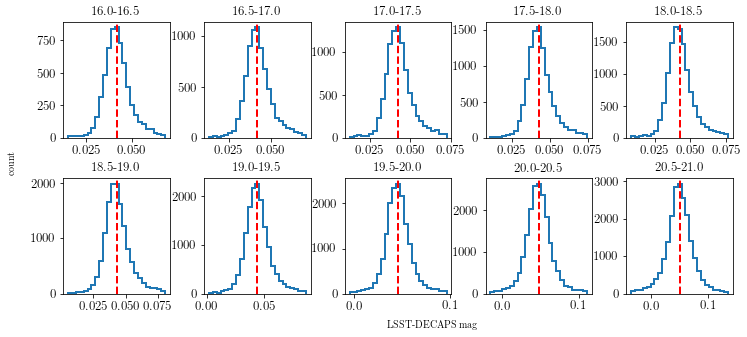

In [314]:
# Make a plot per visit with three panels, corresponding to three 
# magnitude bins ...
bin_edges = np.arange(16,21.5,0.5)
rows = 2 
cols = 5
assert len(bin_edges[:-1]) == rows*cols
fig,axes = plt.subplots(2,5,figsize=(12,5))
axs = np.ravel(axes)
i= 0 
for ax in axs : 
    mag_min = bin_edges[i]
    mag_max = bin_edges[i+1]
    
    mask_distance = decaps_lsst['d2darcsec'].data < 0.5
    x = decaps_lsst[mask_distance]['decaps_mag']
    y = decaps_lsst[mask_distance]['lsst_mag']
    dm = y-x 
    mask_mag = (mag_min<x)*(x<mag_max)
    dm_bin = dm[mask_mag]
    med = np.median(dm_bin)
    sigG = sigmaG(dm_bin)
    ax.hist(dm_bin, histtype='step', lw=2, range=(med-4*sigG, med+4*sigG), bins=25)
    ax.axvline(med,ls='--', c='red', lw=2)
    ax.set_title(str(mag_min)+'-'+str(mag_max),fontweight='bold')
    i += 1 

fig.subplots_adjust(hspace=0.35, wspace=0.32
                   )
fig.text(0.5,0.03, 'LSST-DECAPS mag')
fig.text(0.06, 0.5, 'count', rotation='vertical')
plt.savefig('rms_decaps_lsst_'+str(visit)+'hist_panel.png', bbox_inches='tight')

# We plot histograms of magnitude difference in bins of decaps magnitude. 
# The limits on each histogram are +/- 4 sigmaG  from the median,
# with both sigmaG and median calcualated based on unclipped magnitude difference


visit  525846   0  of  36 , N= 42783.0
visit  525900   1  of  36 , N= 44951.0
visit  529989   2  of  36 , N= 48848.5
visit  525814   3  of  36 , N= 68355.0
visit  527096   4  of  36 , N= 68990.5
visit  529974   5  of  36 , N= 72612.0
visit  644125   6  of  36 , N= 73788.0
visit  527247   7  of  36 , N= 82461.0
visit  611980   8  of  36 , N= 96971.5
visit  527246   9  of  36 , N= 102080.0
visit  527296   10  of  36 , N= 111708.5
visit  645251   11  of  36 , N= 112634.5
visit  611970   12  of  36 , N= 112664.5
visit  640891   13  of  36 , N= 113060.0
visit  525838   14  of  36 , N= 120527.0
visit  611969   15  of  36 , N= 121780.5
visit  526413   16  of  36 , N= 131839.0
visit  525837   17  of  36 , N= 135593.0
visit  611529   18  of  36 , N= 136508.5
visit  527300   19  of  36 , N= 137681.0
visit  525920   20  of  36 , N= 143418.0
visit  567283   21  of  36 , N= 146874.5
visit  525904   22  of  36 , N= 158668.5
visit  609754   23  of  36 , N= 159080.0
visit  526152   24  of  36 , N= 184

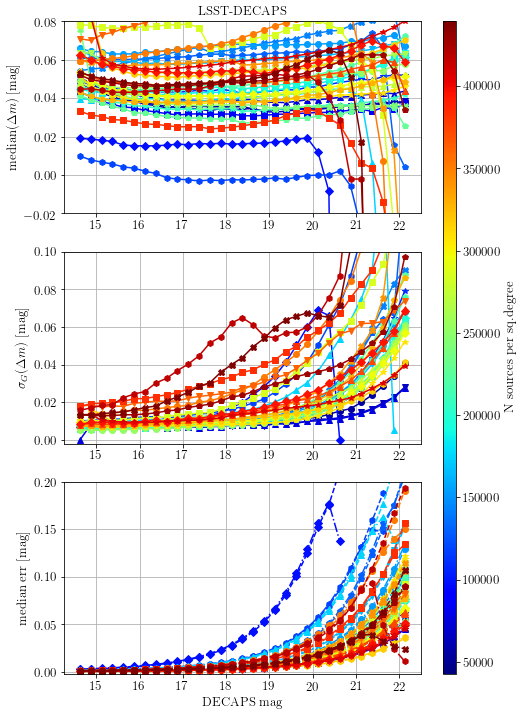

In [239]:
def plot_dmag_stats(decaps_lsst,visit,ax,bins, density,color,marker):
    mask_distance = decaps_lsst['d2darcsec'].data < 0.5
    x = decaps_lsst[mask_distance]['decaps_mag']
    y = decaps_lsst[mask_distance]['lsst_mag']
    e1 = decaps_lsst[mask_distance]['decaps_magerr']
    e2 = decaps_lsst[mask_distance]['lsst_magerr']
    dm = y-x 
    
    # calculate the median delta mag per bin 
    median = bs(x,dm, bins=bins,statistic='median')
    med = median.statistic
    
    # calculate the spread of delta mag  : sigmaG 
    spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
    sig = spread_sig.statistic
    
    # calculate the median error 
    median_error1 = bs(x,e1, bins=bins, statistic='median')
    median_error2 = bs(x,e2, bins=bins, statistic='median')
    
    # from bin edges to bin_centers.... 
    bin_centers = (bins[:-1] + bins[1:])/2
    
    # plot median dmag 
    ax[0].plot(bin_centers, med, label=density, marker=marker, c=color)
    
    # plot sigmaG dmag 
    ax[1].plot(bin_centers, sig, label=density, marker=marker, c=color)
    
    # plot median error 
    ax[2].plot(bin_centers, median_error1.statistic, 
               label=density, marker=marker, c=color, ls='--')
    
    ax[2].plot(bin_centers, median_error2.statistic, 
               label=density, marker=marker, c=color, ls='-.')

# Plot all visits on one panel : 
fig, ax=  plt.subplots(3,1, figsize=(8,12))
bins = np.arange(14.5,22.5,0.25)
cmap = matplotlib.cm.get_cmap('jet')

visits = visit_table['visit'][3:]
densities = visit_table['mean_N_per_sq_deg'][3:]

N = len(densities)
markers = ['o','v', '^','s','D','*', 'h','p','X']
colors = (np.arange(len(densities))+1)/N

i = 0 

for visit in visits : 
    density = densities[i]
    print('visit ', visit,' ',i, ' of ', len(visits), ', N=',density)
    color = cmap(colors[densities == density][0])
    marker = markers[i%len(markers)]
    decaps_lsst = Table.read('decaps-lsst-'+str(visit)+'.txt', format='ascii')
    plot_dmag_stats(decaps_lsst, visit, ax, bins, density, color, marker) 
    i += 1 

# Add a colorbar      
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(densities), 
                           vmax=max(densities)))
sm._A = []
cax,kw = matplotlib.colorbar.make_axes([ax for ax in ax.flat],
                                      aspect=50)
plt.colorbar(sm, cax=cax, label='N sources per sq.degree') 

# Set plot names .. 
ax[0].set_title('LSST-DECAPS')

ax[0].set_ylabel('median'+r'$ (\Delta m)$'+' [mag]')
ax[0].set_ylim(-0.02, 0.08)

ax[1].set_ylabel(r'$\sigma_{G} (\Delta m)$ [mag]')
ax[1].set_ylim(-0.002,0.1)

ax[2].set_ylabel('median err [mag]')
ax[2].set_ylim(-0.002,0.2)

ax[2].set_xlabel('DECAPS mag')

# put the legend outside the plot 
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
for i in range(len(ax)):
    ax[i].grid()

plt.savefig('decaps_lsst_rms_plot.png', bbox_inches='tight')


In [185]:
#densities

## Plot d2d : deprecated in favor of considering $\Delta \alpha$, $\Delta \delta$

## Compare zeropoints 

In [83]:
################################
########### ASIDE ##############
################################


# Since it looks like the problem lies in zeropoints, 
# compare the zero points : 


visits = {611529, 611970, 644125, 611969, 611980}

zeropoints = {'decaps_single':[],'lsst_single':[], 'decaps_calib':[], 
               'visit':[]}

for visit in visits : 
    zeropoints['visit'].append(visit)
    cat_name = imdb[imdb['expnum'] == visit]['catfname'].data[0]
    singleDir = '../raw_data/decaps_catalogs/single_epoch/'
    file_name  = singleDir + cat_name
    decaps_hdu = fits.open(file_name)
    # obtain the calibrated decaps zeropoint, 
    # based on the observation date ... 
    mjd_obs = decaps_hdu[0].header['MJD-OBS']
    m = zps_table['mjd_obs'] == mjd_obs
    decaps_calibrated_zpt = zps_table['zp'][m].data[0]
    zeropoints['decaps_calib'].append(decaps_calibrated_zpt)

    # use the single-epoch decaps zeropoint 
    decaps_single_zpt = decaps_hdu[0].header['MAGZERO']  
    zeropoints['decaps_single'].append(decaps_single_zpt)

    outDir = '../data_products/LSST_Stack_processing/DECam/'+str(visit)+'/'
    # first check calexp for zero point magnitude
    calexp_files = os.listdir(outDir+'calexp/')
    calexp_hdu = fits.open(outDir+'calexp/' + calexp_files[0])
    lsst_zeropoint = calexp_hdu[0].header['MAGZERO']
    zeropoints['lsst_single'].append(lsst_zeropoint)

zpts_table = Table(zeropoints)

In [85]:
zpts_table.write('zeropoints.txt', format='ascii')

In [41]:
################################
########### ASIDE ##############
################################
# Clean using the LSST mask information ... 
hdu = fits.open('src-0'+str(visit)+'_10.fits')
ccd_data = Table(hdu[1].data)
flag_count = len(ccd_data['flags'][0])
flag_dictionary = {'index':[],
                   'flag_number':[],
                  'flag_name':[],
                  'flag_doc':[]
                  }
for flag_number in range(1,1+flag_count):
    flag_dictionary['index'].append(flag_number-1)
    flag_dictionary['flag_number'].append(flag_number)
    flag_dictionary['flag_doc'].append(hdu[1].header['TFDOC'+str(flag_number)])
    flag_dictionary['flag_name'].append(hdu[1].header['TFLAG'+str(flag_number)])
Table(flag_dictionary).write(str(visit)+'_flag_dict.dat', format='ascii',
                            overwrite='True')

# It may be too cumbersome to use the FITS-compressed mask data to 
# clean the LSST dictionary ...
# In a way , since we are matching LSST to DECAPS, 
# all the bad sources in the LSST catalog don't matter as much 
#table(table(tabl# since they simply wouldn't have a good match  anyway . Table(flag_dictionary)

In [34]:
len(Table(flag_dictionary))

83

In [42]:
Table(flag_dictionary)[58:74]

index,flag_number,flag_name,flag_doc
int64,int64,str54,str106
58,59,base_GaussianFlux_flag,General Failure Flag
59,60,base_PixelFlags_flag,"general failure flag, set if anything went wring"
60,61,base_PixelFlags_flag_offimage,Source center is off image
61,62,base_PixelFlags_flag_edge,Source is outside usable exposure region (masked EDGE or NO_DATA)
62,63,base_PixelFlags_flag_interpolated,Interpolated pixel in the Source footprint
63,64,base_PixelFlags_flag_saturated,Saturated pixel in the Source footprint
64,65,base_PixelFlags_flag_cr,Cosmic ray in the Source footprint
65,66,base_PixelFlags_flag_bad,Bad pixel in the Source footprint
66,67,base_PixelFlags_flag_suspect,Source's footprint includes suspect pixels


In [39]:
ccd_data[0]['flags'][0]

True

In [ ]:
## Match DECAPS to LSST

## CODE TO DELETE LATER 


def cross_match_catalogs(decaps_clean,lsst_clean, visit, save_tables=False):

    # Match sources from  decaps to lsst  per ccd  : 
    # we want to find out how many decaps sources 
    # have an LSST match ...

    # decam coordinates
    decaps_coord = SkyCoord(ra  = decaps_clean['decaps_ra']*u.degree, 
                           dec = decaps_clean['decaps_dec']*u.degree)  

    # lsst coordinates : in radians ! 
    lsst_coord = SkyCoord(ra = lsst_clean['lsst_ra']*u.radian, 
                          dec= lsst_clean['lsst_dec']*u.radian)  


    # indices are into lsst catalog 
    idx, d2d, d3d = decaps_coord.match_to_catalog_sky(lsst_coord)  

    # stack the two catalogs 
    decaps_lsst = hstack([decaps_clean ,lsst_clean[idx]],
                   table_names=['decaps','lsst']  )

    print('There are %d decaps sources  and %d lsst sources.'%(len(decaps_coord),
                                                          len(lsst_coord))
         )

    # matches within 0.5 arcsec...
    cut_arcsec = 0.5 
    mask_arcsec = d2d.arcsec < cut_arcsec
    decaps_lsst['d2darcsec'] = d2d.arcsec

    # matches within 0.5 mag from one another ... 
    decaps_lsst['dmag'] = decaps_lsst['decaps_mag'] - decaps_lsst['lsst_mag']
    cut_mag = 0.5
    mask_mag = abs(decaps_lsst['dmag'].data) < cut_mag
    mask_comb  = mask_arcsec * mask_mag


    print(' %d decaps srcs have a lsst match within %.1f arcsec'%(
        np.sum(mask_arcsec), cut_arcsec)
         )
    print(' %d decaps srcs have a  lsst match within %.1f mag'%(
        np.sum(mask_mag), cut_mag)
         )
    print(' %d decaps srcs have an lsst match fulfilling both criteria'%np.sum(mask_comb)
         )

    # Using the original table, make a flag
    # column with decaps sources that have a good lsst match. 
    # Initialize the flag column with zeros : 
    decaps_lsst['lsst_match'] = 0

    # Set to 1 only where the match is good, i.e. fulfills the combined selection masks
    decaps_lsst['lsst_match'][mask_comb] = 1 
    
    if save_tables == True : 
        fname  = 'decaps-lsst-'+str(visit)+'.txt'
        print('Saving as ', fname)
        decaps_lsst.write(fname, format='ascii',overwrite=True)
    return decaps_lsst